## Here a sensitiivity framework builduing on the work by Chas and AlexR is developed. <br>
Work in progress <br>
AlexF 20190813


In [1065]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = (24)
plt.rcParams['xtick.labelsize']="medium"


In [767]:
# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

def osci_pos_triang_func(stroke,time,frequency,width=0.5):
    osci_pos_triang=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return osci_pos_triang

# determine the force for a given point in time using the transformation to position
## sinusoidal movement
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

## triangle movement
def osci_force_func_tri(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang = osci_pos_triang_func(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)

# normalization for used ASD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

def generate_white_noise(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    fft = np.real(np.fft.rfft(noise_randomized))
    freq3 = np.fft.rfftfreq(length, d=1./fs)
    ps = fft*fft.conj().real*fft_norm(len(noise_randomized),fs)**2
    return ps,freq3

# make some white noise and finally learn how and why things are normalized that way
def generate_white_noise2(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    psd_noise,freq_n = psd(noise_randomized,NFFT=length,Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    norm=0.5*fs
    return psd_noise*norm,freq_n

# define a function to obtain the response given a number of harmonics
def function_response(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,plot):
    force_vec = force_vec * alpha
    time = np.arange(0,int_time,1/sampling_frequency)
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)), 
                         Fs=sampling_frequency, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,340)
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [364]:
## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])

res_dict_side_by_side = pkl.load( open('/home/analysis_user/Results/Sensitivity/rbead_2.4e-06_sep_7.5e-06_height_0.p', 'rb'))


In [365]:
## initate a few values in order to do diagnostics
int_time = 1 # keep that 1 for now
alpha = 1 # alpha to scale the yukawa force
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
separation = 7.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary

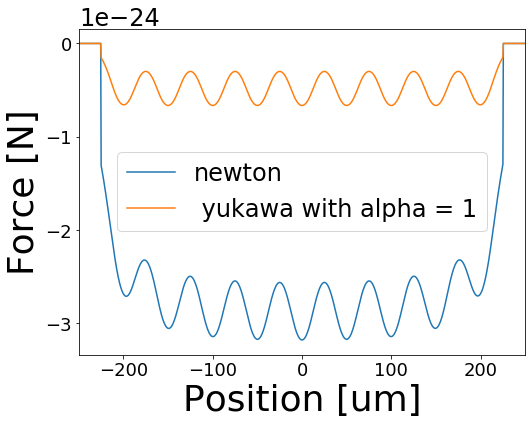

In [366]:
# let's have a look at the force in the spatial dimension

plt.plot(1e6*pos_x,force_x, label = "newton")
plt.plot(1e6*pos_x,force_x_yuk, label = " yukawa with alpha = %d" %alpha)
plt.ylabel("Force [N]", fontsize =36)
plt.yticks(fontsize = 18)
plt.xlabel("Position [um]", fontsize = 36)
plt.xticks(fontsize = 18)
plt.xlim(-250,250)
plt.legend(fontsize = 24)


(array([-300., -200., -100.,    0.,  100.,  200.,  300.]),
 <a list of 7 Text yticklabel objects>)

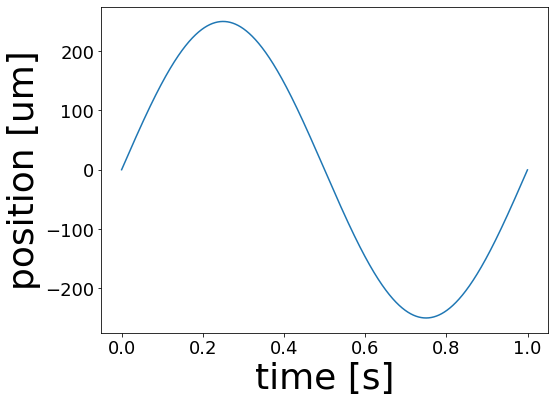

In [367]:
plt.plot(time,1e6*osci_pos_func(time=time,frequency=1,stroke=500e-6))
plt.xlabel("time [s]", fontsize = 36)
plt.xticks(fontsize = 18)
plt.ylabel("position [um]", fontsize = 36)
plt.yticks(fontsize = 18)

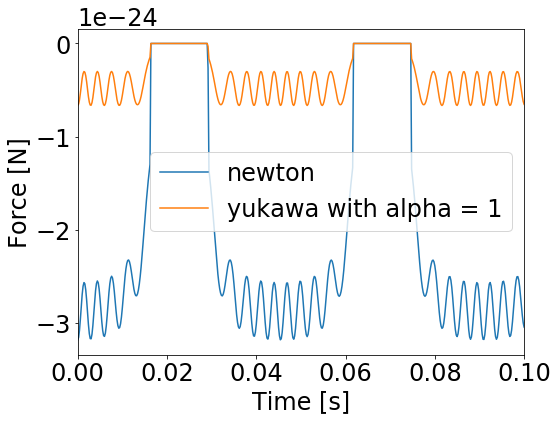

In [368]:
# now force as a function of time

plt.plot(time,osci_force_func(500e-6,time,11,pos_x,force_x), label="newton")
plt.plot(time,osci_force_func(500e-6,time,11,pos_x,force_x_yuk), label =  "yukawa with alpha = %d" %alpha)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,0.1)
plt.legend()

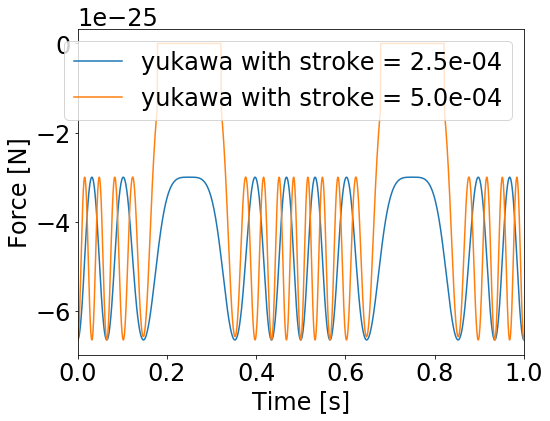

In [369]:
# now force as a function of time with different strokes

stroke1=250e-6
stroke2=500e-6
plt.plot(time,osci_force_func(stroke1,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(time,osci_force_func(stroke2,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke2)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,1)
plt.legend()

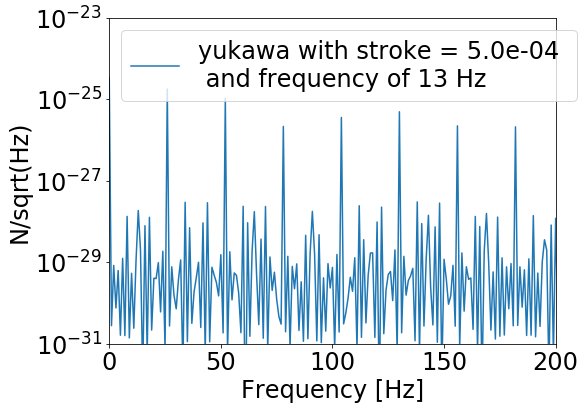

In [673]:
## lets move to the amplitude spectral density 

frequency = 13
psd_dat,freq = psd(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk), 
                   NFFT=len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)), Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

psd_dat2,freq2 = psd(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk),
                     NFFT=len(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk)),Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

#plt.plot(freq,np.sqrt(psd_dat),label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(freq2,np.sqrt(psd_dat2),alpha=1,label =  "yukawa with stroke = %2.1e \n and frequency of %d Hz" %(stroke2,frequency))
plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,200)
plt.ylim(1e-31,1e-23)
plt.ylabel("N/sqrt(Hz)")
plt.legend(fontsize=24)
#plt.xscale("log")

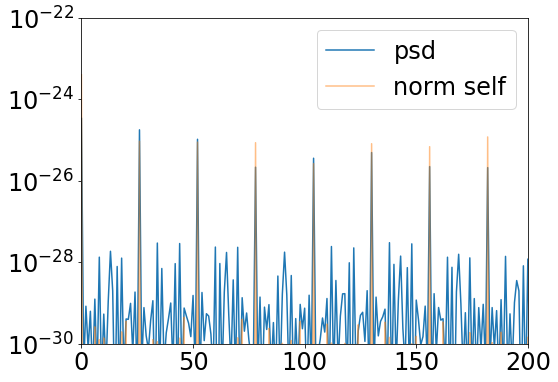

In [691]:
### for cross checks implemented a complementary way to calculate the spectral densities

fft = np.real(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x)))
freq3 = np.fft.rfftfreq(5000, d=1./5000)
ps = fft*fft.conj().real*fft_norm(len(osci_force_func(stroke1,time,frequency,pos_x,force_x)),5000)**2

plt.plot(freq2,np.sqrt(psd_dat2),label="psd")
plt.plot(freq3,np.sqrt(ps),alpha=0.5, label = "norm self")
plt.yscale("log")
plt.xlim(0,200)
plt.ylim(1e-30,1e-22)
plt.legend()
plt.show()

In [680]:
def noise_response(no_of_harmonics,frequency,noise_floor):
    noise_response = 0
    noise_value = generate_white_noise(5000,5000,noise_floor)[0]
    for j in np.arange(1,no_of_harmonics+1):
        noise_response += noise_value[frequency*j]
    return noise_response

def fraction_of_histo(input_histo,bins=500,intervall=0.68):
    hist_list =[]
    h1 = plt.hist(input_histo,bins,density=True,cumulative=True)
    [hist_list.append(h1[1][bins]) for bins in np.arange(0,len(h1[1])-1,1) if h1[0][bins]>intervall]
    return np.min(hist_list)
          

In [681]:
noise_histo = []
for j in np.arange(0,5000,1):
    noise_histo.append(np.sqrt(noise_response(3,13,1e-18)))
    

3.9674124543066186e-20

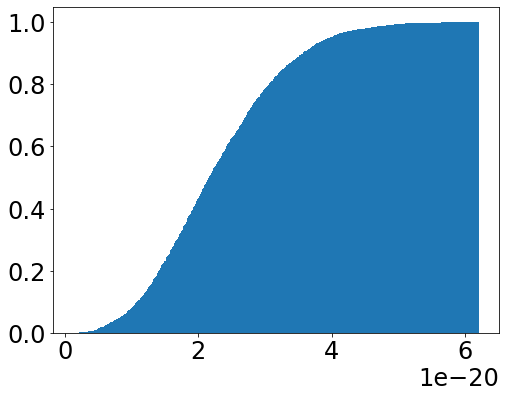

In [682]:
fraction_of_histo(noise_histo,intervall=0.95)

In [773]:
def generate_white_noise(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    fft = np.real(np.fft.rfft(noise_randomized))
    freq3 = np.fft.rfftfreq(length, d=1./fs)
    ps = fft*fft.conj().real*fft_norm(len(noise_randomized),fs)**2
    return ps,freq3

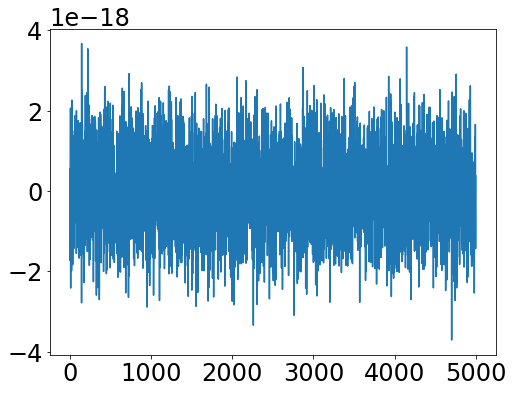

In [758]:
plt.plot(noise_floor * np.random.randn(5000))

2.533339605709125e-33
2.4880916788313927e-33
7.897477643743618e-19
1.1082488583758538e-20


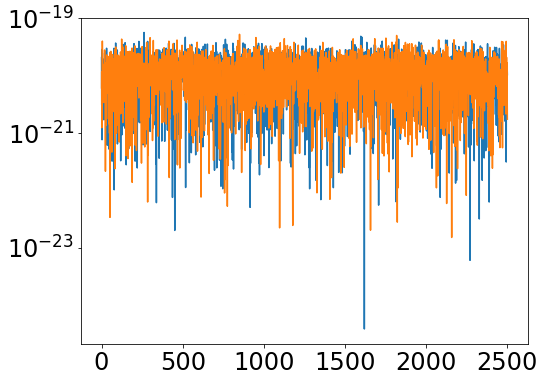

In [790]:
plt.plot(generate_white_noise(5000,5000,1e-18)[1],np.sqrt(generate_white_noise(5000,5000,1e-18)[0]))
plt.plot(generate_white_noise2(5000,5000,1e-18)[1],np.sqrt(generate_white_noise(5000,5000,1e-18)[0]))
print(np.sum(generate_white_noise(5000,5000,1e-18)[0])*5000)
print(np.sum(generate_white_noise2(5000,5000,1e-18)[0]))
print(np.mean(np.sqrt(generate_white_noise(5000,5000,1e-18)[0]*5000)))
print(np.mean(np.sqrt(generate_white_noise(5000,5000,1e-18)[0])))
plt.yscale("log")

2.7 np
7.309038765049681 var
7.309232135220186 7.308939777629081 sum,mean
[2.15491091 1.91535901 3.2994932  ... 3.83025832 1.39613622 0.61743538] k 2.3951020371217973


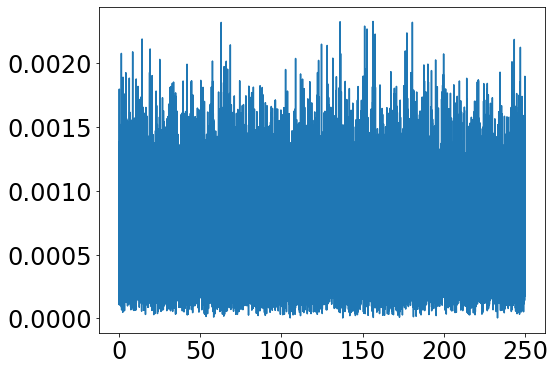

In [1063]:
fs = 500
N = 50000
amp = 0*2*np.sqrt(2)
freq = 1234.0
noise_power = 2.7#0.042 * fs / 2
time = np.arange(N) / fs
x=0
x = amp*np.sin(2*np.pi*freq*time)
#x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
x = noise_power * np.random.randn(N)
print(noise_power, "np")

print(np.var(x), "var")
fft = np.abs(np.fft.rfft(x))
freq3 = np.fft.rfftfreq(int(N), d=1./fs) 
ps = fft*fft.conj().real/N#*fft_norm(fsamp=fs,N=N)**2

print(np.sum(ps)*2/N, np.mean(ps),"sum,mean")
print(np.sqrt(ps),"k", np.mean(np.sqrt(ps)))
plt.plot(freq3,np.sqrt(ps)*fft_norm(fsamp=fs,N=N))

#plt.yscale("log")
#plt.show()
#plt.plot(time,x)
#plt.show()

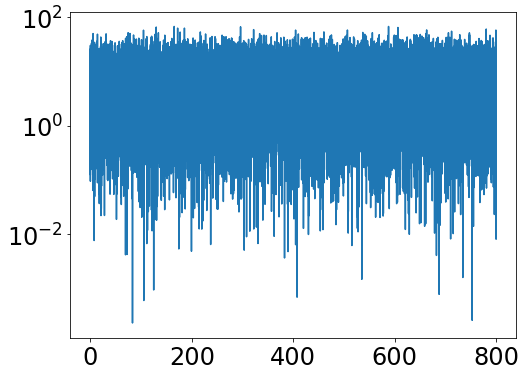

In [1047]:
plt.plot(freq3,ps)
plt.yscale("log")

8.341628604893266e-21
1.1023700489333656e-20


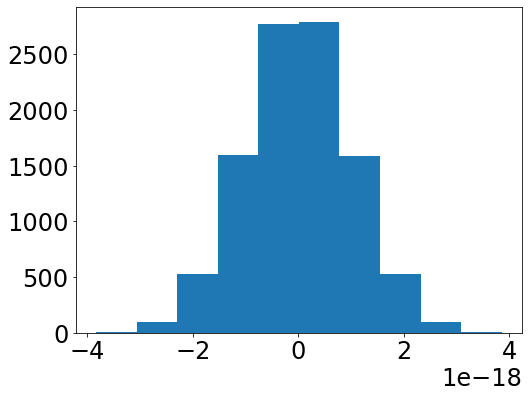

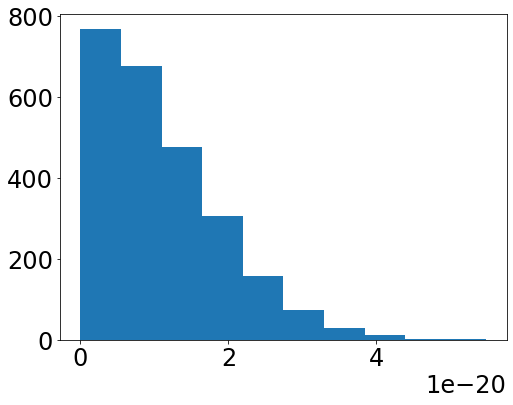

In [875]:
noise_floor = 1e-18
noise_value2 = np.sqrt(generate_white_noise(5000,5000,noise_floor)[0])
noise_value = noise_floor * np.random.randn(10000)
print(np.std(noise_value2))
print(np.mean(noise_value2))
plt.hist(noise_value)
plt.show()
plt.hist(noise_value2)
plt.show()

(array([ 78., 154., 182., 204., 139., 122.,  53.,  43.,  17.,   8.]),
 array([2.33685663e-15, 2.60877524e-14, 4.98386482e-14, 7.35895440e-14,
        9.73404398e-14, 1.21091336e-13, 1.44842231e-13, 1.68593127e-13,
        1.92344023e-13, 2.16094919e-13, 2.39845814e-13]),
 <a list of 10 Patch objects>)

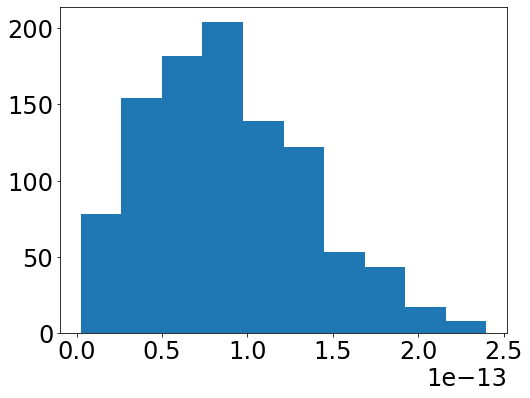

In [454]:
noise_list=[]
for j in np.arange(0,1000):
    noise_list.append(noise_response(1,13,1e-13))
plt.hist(np.sqrt(noise_list))    


In [349]:
alpha_list=[]
no_of_harmonics=np.arange(1,100,1)
stroke = np.arange(50e-6,550e-6,50e-6)
integration_time_simple = 1e5
noise_value = generate_white_noise(5000,5000,1e-18)[0]
frequency=10
stroke=500e-6

### FALSCH

for j in no_of_harmonics+1:
    for i in np.geomspace(1,1e9,256):
        f = function_response(i,1,5000,pos_x,force_x_yuk,stroke,frequency,j,plot=False)
        #print(f)
        if(f>(np.sqrt(noise_value[frequency*j])*j/np.sqrt(integration_time_simple))):
            #print("The maximum alpha is %2.2E with %.2d harmonics" %(i,j))
            alpha_list.append(i)
            break


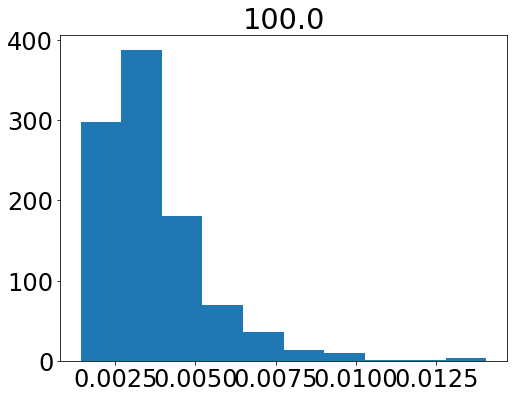

0.0036606028014864165 1.7713698340547837e-23 4.7805255462963046e-21


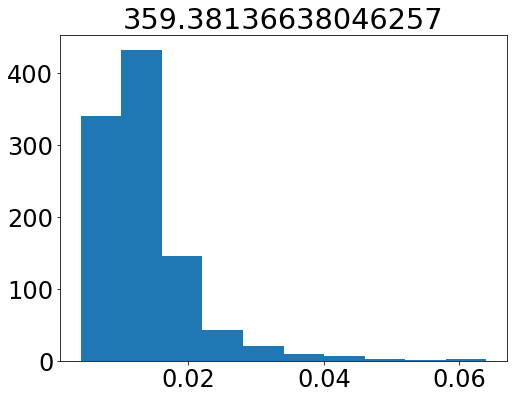

0.013512369286850623 6.365973113277413e-23 8.123921095715736e-21


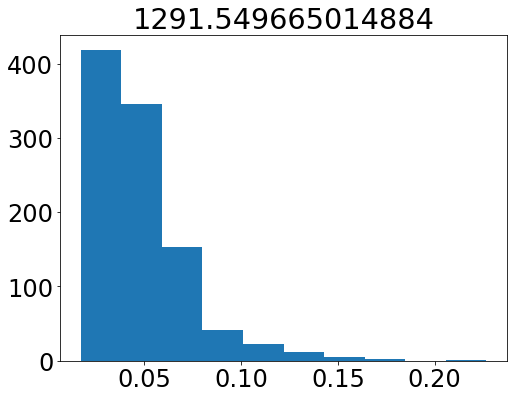

0.04853749814536211 2.2878121157909266e-22 4.437293089937524e-21


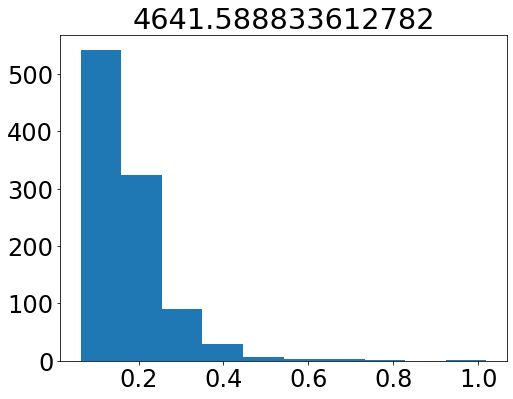

0.17668739681349396 8.22197044194721e-22 6.103146663671647e-21


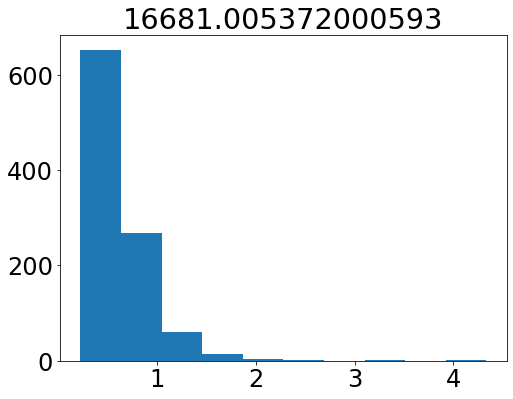

0.6202606085476917 2.9548229717667634e-21 4.297021641288934e-21


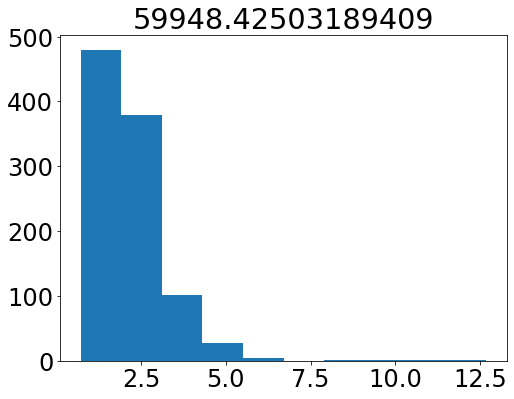

2.2229931084671732 1.0619083170059187e-20 1.0803340572651873e-20


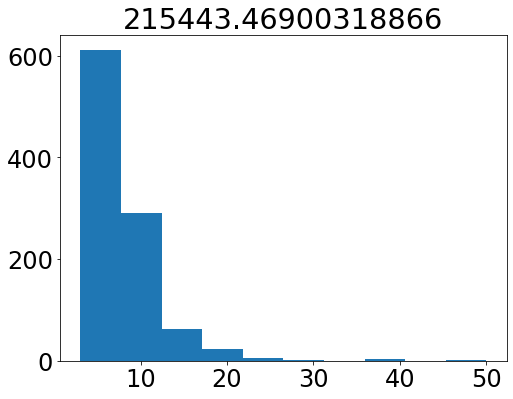

8.013063135364332 3.816300619363652e-20 2.2496257187173865e-21


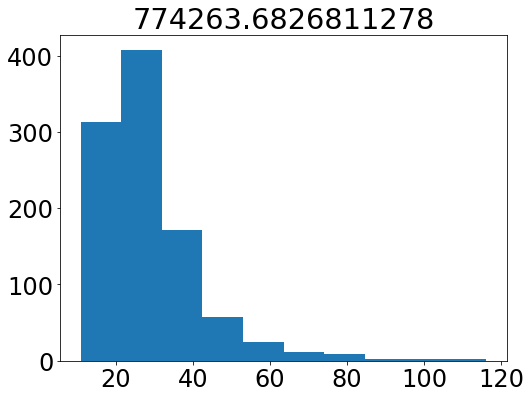

28.750719300538528 1.3715073311055148e-19 7.661199527279555e-21


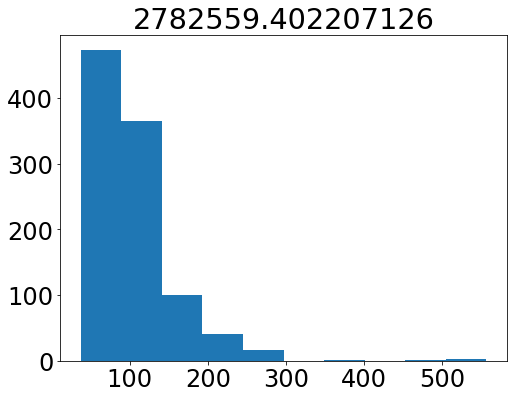

104.45214513262741 4.928941786535214e-19 3.446464212598726e-21


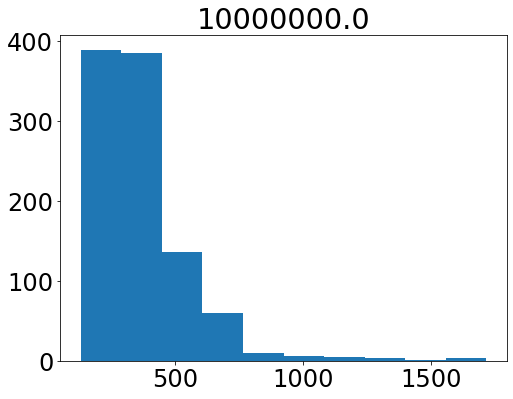

372.0131980768538 1.7713698340547833e-18 4.587413404820002e-21


In [436]:
no_of_harmonics=2#np.arange(1,100,1)
stroke = np.arange(50e-6,550e-6,50e-6)
integration_time_simple = 1e5
noise_floor = 1e-18
frequency=10
stroke=500e-6

for i in np.geomspace(1e2,1e7,10):
    ratio_list=[]
    f = function_response(i,1,5000,pos_x,force_x_yuk,stroke,frequency,no_of_harmonics,plot=False)
    for j in np.arange(0,1000):
        noise_value=(noise_response(no_of_harmonics,frequency,noise_floor)/np.sqrt(integration_time_simple))
        ratio_list.append(f/noise_value)
    plt.hist(ratio_list)
    plt.title(i)
    plt.show()
    print(np.mean(ratio_list),np.mean(f),np.mean(noise_value))

In [350]:
alpha_list

[35722.44501871464,
 30363.577601873585,
 12419.887072831294,
 49444.461011588304,
 17190.722018585748,
 38746.75120456128,
 35722.44501871464,
 142213.61511653377,
 74231.49980177928,
 45585.164821728744,
 49444.461011588304,
 142213.61511653377,
 32934.195473009575,
 68437.4970259087,
 87332.61623828438,
 87332.61623828438,
 120879.57966963426,
 213506.8261712694,
 94726.30307515245,
 196841.94472866112,
 53630.48996942866,
 231582.57699885056,
 231582.57699885056,
 120879.57966963426,
 131113.3937421563,
 154253.59490188223,
 251188.6431509582,
 111444.54707535625,
 167312.89420254444,
 120879.57966963426,
 142213.61511653377,
 181477.80986393234,
 12419.887072831294,
 111444.54707535625,
 68437.4970259087,
 74231.49980177928,
 196841.94472866112,
 131113.3937421563,
 142213.61511653377,
 94726.30307515245,
 94726.30307515245,
 154253.59490188223,
 120879.57966963426,
 68437.4970259087,
 295520.9235202888,
 120879.57966963426,
 251188.6431509582,
 231582.57699885056,
 142213.6151165

The minimum is at 1.24E+04 at 02 harmonics


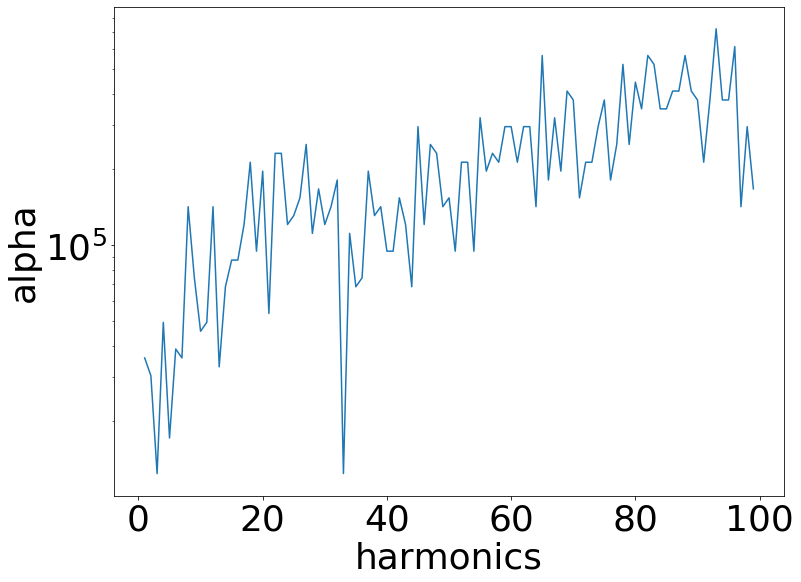

In [351]:
plt.plot(no_of_harmonics,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("harmonics")
print("The minimum is at %2.2E at %.2d harmonics" %(np.min(alpha_list),np.argmin(alpha_list)))
plt.show()

The minimum is at 8.97E+03 


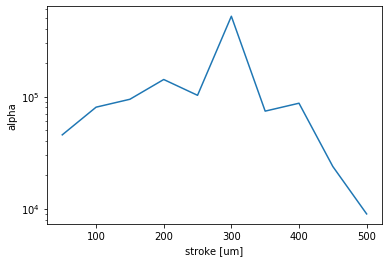

In [610]:
plt.plot(stroke*1e6,alpha_list)            
plt.yscale("log")
plt.ylabel("alpha")
plt.xlabel("stroke [um]")
print("The minimum is at %2.2E " %(np.min(alpha_list)))
plt.show()

/home/data_transfer/data_from_windows/20190812/Bead1/InitialTest/Data42.h5
No cantilever data


(0, 340)

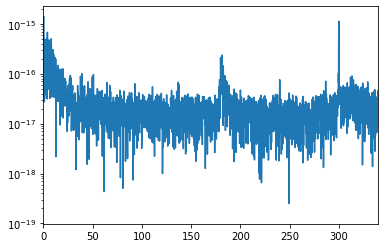

In [637]:
## load real noise spectrum
import numpy as np
import pickle as pickle
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
Year = "2019"
Month = "08"
Day = "12"
BeadNumber = 1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day
Data_File_Number=42
fname = folder+"/Bead"+str(BeadNumber)+"/InitialTest"+"/Data%d.h5" % Data_File_Number
print(fname)
BDF = BeadDataFile.BeadDataFile(fname)
fsamp=5000
res = 50000
#res=50000
data=BDF.xyz
data_det=signal.detrend(data)
y_1000=1*data_det[1]
z_1000=100*data_det[2]
xpsd, freqs = psd(data_det[0], Fs = fsamp, NFFT = res)
ypsd, freqs = psd(y_1000, Fs = fsamp, NFFT = res)
zpsd, freqs = psd(z_1000, Fs = fsamp, NFFT = res)
plt.plot(freqs,noise_floor/np.sqrt(xpsd[121*10])*np.sqrt(xpsd))
plt.yscale("log")
plt.xlim(0,340)


In [624]:
len(xpsd)

25001

In [641]:
def noise_response(data,frequency,no_harmonics,normalization=1):
    response=0
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(data[i*frequency*10])
        #print(response,i*frequency)
    return response*normalization

6.2711886904440515e-18
3.16227766016838e-20
1.7730784090655124e-18


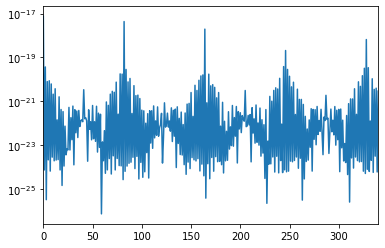

In [681]:
noise_floor = 1e-18 # N
integration_time_simple = 1000
no_of_harmonics=5
frequency=41
print(function_response(4e6,1,5000,pos_x,force_x_yuk,500e-6,frequency,no_of_harmonics,plot=True))
print(noise_floor/np.sqrt(integration_time_simple))
print(noise_response(np.sqrt(xpsd),frequency,no_of_harmonics,noise_floor/np.sqrt(xpsd[121*10])))

In [ ]:
load data

20190717/Bead5/NoiseFluctuation.

In [1069]:
# load the data
Day = "17"
Month = "07"
Year = "2019"
BeadNumber = 5
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/NoiseFluctuation/"
files = load_dir(folder, file_prefix = 'Discharge', max_file=500)
#pos_x = files[0].cant_pos[0]
#pos_y = files[0].cant_pos[1]
#pos_z = files[0].cant_pos[2]
#quad_sum = files[0].quad_sum


Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinni

In [1135]:
x2_reshaped = {}

for i in np.arange(0,5):
    x2_reshaped[i] = np.reshape(files[i].x2,(120,5000))



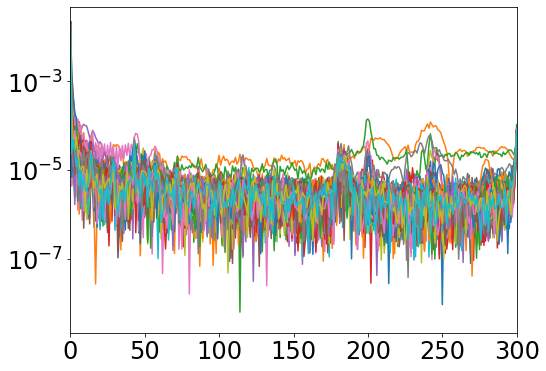

In [1155]:
psd_from_data= {}
for i in np.arange(0,120):
    psd_from_data[i],freq_data = psd(x2_reshaped[0][i],NFFT=5000,Fs=5000, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    #print(len(psd_from_data[i]),len(freq_data))
    plt.plot(freq_data,np.sqrt(psd_from_data[i]))
    plt.yscale("log")
    plt.xlim(0,300)

In [1209]:
psd_at_freq = {}
no_of_harmonics = 10
mean_psd = 0
for k in np.arange(1,no_of_harmonics+1,1):
    psd_lists=[]
    for i in np.arange(0,len(psd_from_data),1):
        psd_lists.append(psd_from_data[i][k*13])
    psd_at_freq[k] = psd_lists
    mean_psd += np.mean(np.sqrt(psd_at_freq[k]))


TypeError: can't multiply sequence by non-int of type 'float'

(100, 200)

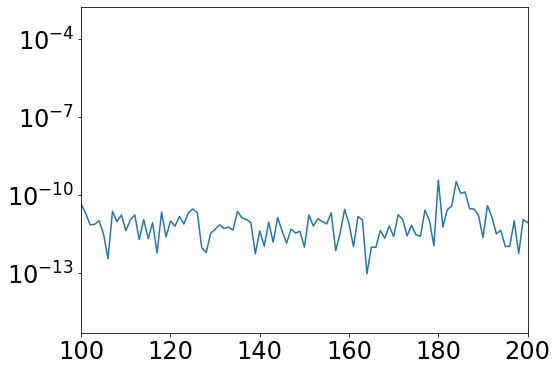

In [1117]:
plt.plot(freq_data,psd_from_data)
plt.yscale("log")
plt.xlim(100,200)

In [477]:
# my_to_do_list

# harmonics vs alpha (mo) - done
# comparison as a function of integration time (mo) - done
# comparison as a function of stroke with harmonics (mo) - done
# comparison vs real noise (mo) - basically implemented
# comparison for different frequencies (mo) - 
# make the script nice (di) - tried
# do different lambda (di)
# do different separation (di)
# implement confidence intervall
# implement noise random 
# implement different functions for shaking
# in and out (mi+do)
# second attractor (fr)
# change attractor - finger size, size, finger pattern (future)
# use peak height information for likelihood comparison